In [1]:
from tomoSegmentPipeline.utils import setup
from tomoSegmentPipeline.dataloader import to_categorical, transpose_to_channels_first
from tomoSegmentPipeline.trainWrapper import make_trainer
from tomoSegmentPipeline.showcaseResults import load_model


import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from glob import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

PARENT_PATH = setup.PARENT_PATH

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
train_tomos = ['tomo02', 'tomo03', 'tomo17']
val_tomos = ['tomo32', 'tomo10']
input_type = 'cryoCARE'

nPatches_training = 32


paths_trainData, paths_trainTarget = setup.get_paths(train_tomos, input_type)
paths_valData, paths_valTarget = setup.get_paths(val_tomos, input_type)

if nPatches_training is not None:
    # training with tomo02, 03 and 17 yields 32 patches in total.
    assert nPatches_training<=len(paths_trainData)
    # this guarantees that we always use the same incremental list of random patches
    random.seed(17)
    random_indices = random.sample(range(len(paths_trainData)), len(paths_trainData))[0:nPatches_training]

    print('Random indices used for training: ', random_indices)
    paths_trainData = list(np.array(paths_trainData)[random_indices])
    paths_trainTarget = list(np.array(paths_trainTarget)[random_indices])
    
train_patchCounts = [x.split('/')[-1].split('_')[0] for x in paths_trainData]
train_patchCounts = np.unique(train_patchCounts, return_counts=True)
train_patchCounts = dict(zip(*train_patchCounts))

val_patchCounts = [x.split('/')[-1].split('_')[0] for x in paths_valData]
val_patchCounts = np.unique(val_patchCounts, return_counts=True)
val_patchCounts = dict(zip(*val_patchCounts))

train_patchCounts

Random indices used for training:  [26, 25, 9, 11, 29, 5, 24, 22, 30, 17, 21, 8, 3, 0, 7, 12, 13, 4, 15, 20, 31, 10, 6, 2, 18, 1, 27, 28, 14, 19, 23, 16]


{'tomo02': 10, 'tomo03': 12, 'tomo17': 10}

# Incremental model best validation scores analysis

In [3]:
logs_path = PARENT_PATH + 'data/model_logs/incremental_models/logs/BaselineModel/'
logs_path = Path(logs_path)

model_info = []


for f in logs_path.rglob('*/version_*/'):
    logdir_path = f.as_posix()
    
    model_file = glob(os.path.join(logdir_path, '*.model'))
    if len(model_file)==1:
        model_file = model_file[0]
        
        model_file_split = model_file.split('/')
        
        n_patches = model_file_split[-3]
        n_patches = int(n_patches.replace('nPatches_', ''))
        
        name, input_type, epochs, patch_size, lr, version = model_file_split[-1].split('_')
        epochs = int(epochs.replace('ep', ''))
        version = 'v'+version.replace('.model', '')

        events_path = glob(os.path.join(logdir_path, 'events.*'))[0]
        event_acc = EventAccumulator(events_path)
        event_acc.Reload()

        _, _, values_valLoss = zip(*event_acc.Scalars('hp/val_loss_epoch'))
        best_val_loss_epoch = np.min(values_valLoss)
        best_val_loss_epoch_idx = np.argmin(values_valLoss) #index starts count at 0

        effective_epochs = len(values_valLoss)

        _, _, values_dice = zip(*event_acc.Scalars('hp/val_dice_epoch'))
        _, _, values_trainLoss = zip(*event_acc.Scalars('hp/train_loss_epoch'))

        associated_val_class1_dice = float(values_dice[best_val_loss_epoch_idx])
        associated_train_loss_epoch = float(values_trainLoss[best_val_loss_epoch_idx])

        train_set = str(train_patchCounts)[1:-1].replace(',', ' ')
        train_set = train_set.replace(',', ' -').replace("'", "")

        validation_set = str(val_patchCounts)[1:-1].replace(',', ' ')
        validation_set = validation_set.replace(',', ' -').replace("'", "")

        epochs_str = "%i out of %i" %(effective_epochs, 1000)

        model_info.append([name, input_type, epochs_str, patch_size, n_patches, lr, version, best_val_loss_epoch, associated_val_class1_dice])
    
    else:
        print(f)

/home/haicu/jeronimo.carvajal/Thesis/data/model_logs/incremental_models/logs/BaselineModel/cryoCARE/train02-03-17/nPatches_24/version_0


In [4]:
df_incremental = pd.DataFrame(model_info, columns=['name', 'input_type', 'epochs', 'patch_size', 'n_patches', 'lr', 'version', 'best_val_loss_epoch',
                                             'associated_val_class1_dice'])

df_incremental = df_incremental[df_incremental.n_patches%4==0].sort_values(['input_type', 'n_patches'])
df_incremental = df_incremental[df_incremental.patch_size=='in84']

print(df_incremental.shape)
df_incremental.head()

(206, 9)


,name,input_type,epochs,patch_size,n_patches,lr,version,best_val_loss_epoch,associated_val_class1_dice
80,Baseline,cryoCARE,422 out of 1000,in84,4,lr0.000100,v5,0.196580,0.824392
81,Baseline,cryoCARE,297 out of 1000,in84,4,lr0.000100,v2,0.206653,0.813021
82,Baseline,cryoCARE,1000 out of 1000,in84,4,lr0.000100,v1,0.257936,0.764201
83,Baseline,cryoCARE,81 out of 1000,in84,4,lr0.000100,v0,1.055749,0.000001
84,Baseline,cryoCARE,1000 out of 1000,in84,4,lr0.000100,v3,0.352545,0.679909


In [5]:
# sns.set(rc = {'figure.figsize':(15,8)})
# sns.boxplot(x='input_type', y='associated_val_class1_dice', data=df_incremental[df_incremental.n_patches==24])

In [6]:
loss_means = df_incremental[df_incremental.n_patches%4==0].groupby(['input_type', 'n_patches']).agg({'best_val_loss_epoch':['mean','std','count'], 
                                                                'associated_val_class1_dice':['mean','std']}).reset_index()
loss_means.columns = ['_'.join(col) for col in loss_means.columns]

loss_means.head()

,input_type_,n_patches_,best_val_loss_epoch_mean,best_val_loss_epoch_std,best_val_loss_epoch_count,associated_val_class1_dice_mean,associated_val_class1_dice_std
0,cryoCARE,4,0.379854,0.336154,6,0.648692,0.322246
1,cryoCARE,8,0.314955,0.101475,6,0.715595,0.093007
2,cryoCARE,12,0.183271,0.045550,6,0.833966,0.042940
3,cryoCARE,16,0.262333,0.142363,6,0.761931,0.130267
4,cryoCARE,20,0.179463,0.121327,7,0.838474,0.109932


In [7]:
loss_means[['input_type_', 'n_patches_', 'best_val_loss_epoch_count']].drop_duplicates()

,input_type_,n_patches_,best_val_loss_epoch_count
0,cryoCARE,4,6
1,cryoCARE,8,6
2,cryoCARE,12,6
3,cryoCARE,16,6
4,cryoCARE,20,7
5,cryoCARE,24,6
6,cryoCARE,28,6
7,cryoCARE,32,6
8,cryoCARE+isoNET,4,7
9,cryoCARE+isoNET,8,6


Text(0.5, 1.0, 'Standard deviation by number of input patches per input type')

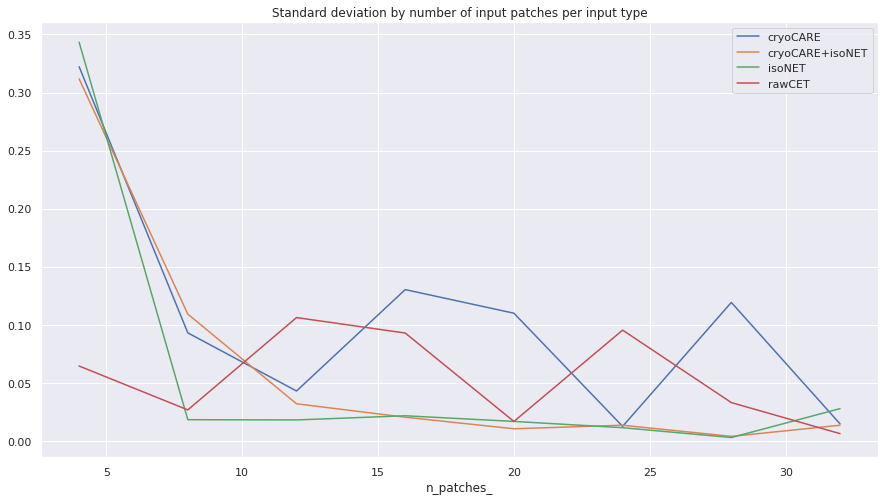

In [8]:
sns.set(rc = {'figure.figsize':(15,8)})
loss_means.set_index('n_patches_').groupby('input_type_')['associated_val_class1_dice_std'].plot(legend=True)
plt.title('Standard deviation by number of input patches per input type')

Text(0.5, 1.0, 'Dice score for validation patches as a function of the number of training patches per input type')

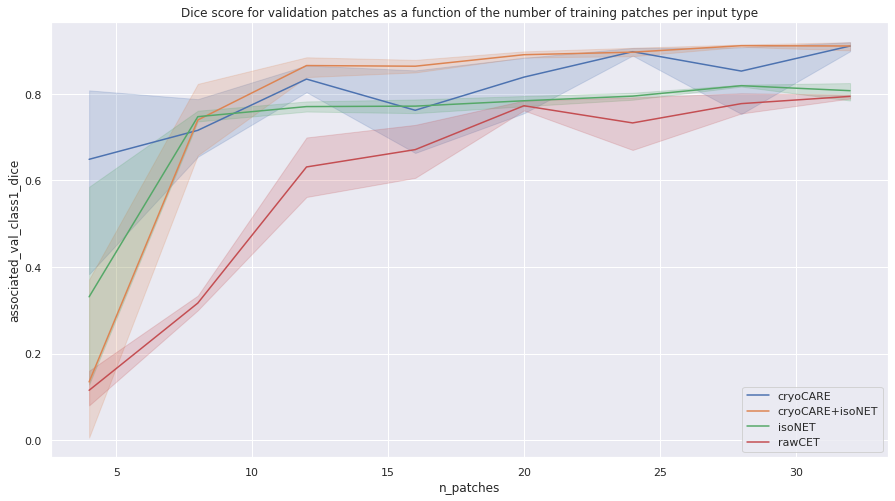

In [9]:
sns.lineplot(x='n_patches', y='associated_val_class1_dice', hue='input_type', data=df_incremental)
plt.legend(loc='lower right')
plt.title('Dice score for validation patches as a function of the number of training patches per input type')

# Mean best dice predictions Baseline Models

In [11]:
logs_path = PARENT_PATH + 'models_1/logs/BaselineModel/'
logs_path = Path(logs_path)

model_info = []


for f in logs_path.rglob('*/version_*/'):
    logdir_path = f.as_posix()
    
    model_file = glob(os.path.join(logdir_path, '*.model'))
    if len(model_file)==1:
        model_file = model_file[0]
        
        model_file_split = model_file.split('/')
        
        input_type = model_file_split[-4]
        
        name, epochs, patch_size, lr, version = model_file_split[-1].split('_')
        epochs = int(epochs.replace('ep', ''))
        version = 'v'+version.replace('.model', '')

        events_path = glob(os.path.join(logdir_path, 'events.*'))[0]
        event_acc = EventAccumulator(events_path)
        event_acc.Reload()

        _, _, values_valLoss = zip(*event_acc.Scalars('hp/val_loss_epoch'))
        best_val_loss_epoch = np.min(values_valLoss)
        best_val_loss_epoch_idx = np.argmin(values_valLoss) #index starts count at 0

        effective_epochs = len(values_valLoss)

        _, _, values_dice = zip(*event_acc.Scalars('hp/val_dice_epoch'))
        _, _, values_trainLoss = zip(*event_acc.Scalars('hp/train_loss_epoch'))

        associated_val_class1_dice = float(values_dice[best_val_loss_epoch_idx])
        associated_train_loss_epoch = float(values_trainLoss[best_val_loss_epoch_idx])

        train_set = str(train_patchCounts)[1:-1].replace(',', ' ')
        train_set = train_set.replace(',', ' -').replace("'", "")

        validation_set = str(val_patchCounts)[1:-1].replace(',', ' ')
        validation_set = validation_set.replace(',', ' -').replace("'", "")

        epochs_str = "%i out of %i" %(effective_epochs, 1000)

        model_info.append([name, input_type, epochs_str, patch_size, lr, version, best_val_loss_epoch, associated_val_class1_dice])
    
    else:
        pass

In [13]:
df_model = pd.DataFrame(model_info, columns=['name', 'input_type', 'epochs', 'patch_size', 'lr', 'version', 'best_val_loss_epoch',
                                             'associated_val_class1_dice'])
print(df_model.shape)
df_model.head()

(18, 8)


,name,input_type,epochs,patch_size,lr,version,best_val_loss_epoch,associated_val_class1_dice
0,Baseline,rawCET,215 out of 1000,in84,lr0.000300,v0,0.205240,0.820816
1,Baseline,rawCET,1000 out of 1000,in84,lr0.000100,v1,0.274763,0.760572
2,Baseline,rawCET,346 out of 1000,in96,lr0.000100,v4,0.289667,0.730407
3,Baseline,rawCET,393 out of 1000,in96,lr0.000100,v3,0.253714,0.765400
4,Baseline,rawCET,301 out of 1000,in56,lr0.000100,v2,0.231046,0.789884


In [15]:
df_model[['name', 'input_type', 'version']].drop_duplicates()

,name,input_type,version
0,Baseline,rawCET,v0
1,Baseline,rawCET,v1
2,Baseline,rawCET,v4
3,Baseline,rawCET,v3
4,Baseline,rawCET,v2
5,Baseline,cryoCARE+isoNET,v0
6,Baseline,cryoCARE+isoNET,v1
7,Baseline,cryoCARE+isoNET,v3
8,Baseline,cryoCARE+isoNET,v2
9,Baseline,isoNET,v0


<AxesSubplot:xlabel='input_type', ylabel='associated_val_class1_dice'>

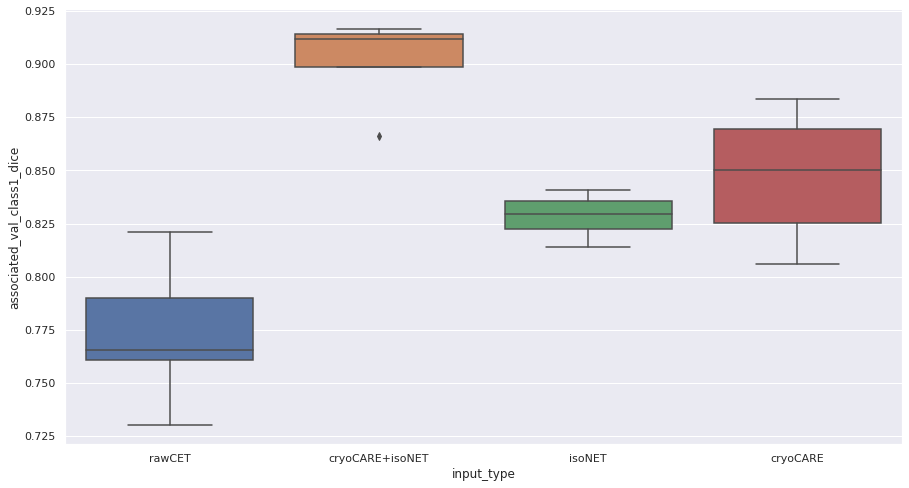

In [14]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.boxplot(x='input_type', y='associated_val_class1_dice', data=df_model)

# Mean best dice predictions for LowBaseline Models

In [31]:
logs_path = PARENT_PATH + 'models_1/logs/LowBaselineModel/'
logs_path = Path(logs_path)

model_info = []


for f in logs_path.rglob('*/version_*/'):
    logdir_path = f.as_posix()
    
    model_file = glob(os.path.join(logdir_path, '*.model'))
    if len(model_file)==1:
        model_file = model_file[0]
        
        model_file_split = model_file.split('/')
        
        input_type = model_file_split[-4]
        train_tomo = model_file_split[-3]
        
        name, epochs, patch_size, lr, version = model_file_split[-1].split('_')
        epochs = int(epochs.replace('ep', ''))
        version = 'v'+version.replace('.model', '')

        events_path = glob(os.path.join(logdir_path, 'events.*'))[0]
        event_acc = EventAccumulator(events_path)
        event_acc.Reload()

        _, _, values_valLoss = zip(*event_acc.Scalars('hp/val_loss_epoch'))
        best_val_loss_epoch = np.min(values_valLoss)
        best_val_loss_epoch_idx = np.argmin(values_valLoss) #index starts count at 0

        effective_epochs = len(values_valLoss)

        _, _, values_dice = zip(*event_acc.Scalars('hp/val_dice_epoch'))
        _, _, values_trainLoss = zip(*event_acc.Scalars('hp/train_loss_epoch'))

        associated_val_class1_dice = float(values_dice[best_val_loss_epoch_idx])
        associated_train_loss_epoch = float(values_trainLoss[best_val_loss_epoch_idx])

        train_set = str(train_patchCounts)[1:-1].replace(',', ' ')
        train_set = train_set.replace(',', ' -').replace("'", "")

        validation_set = str(val_patchCounts)[1:-1].replace(',', ' ')
        validation_set = validation_set.replace(',', ' -').replace("'", "")

        epochs_str = "%i out of %i" %(effective_epochs, 1000)

        model_info.append([name, train_tomo, input_type, epochs_str, patch_size, lr, version, best_val_loss_epoch, associated_val_class1_dice])
    
    else:
        pass

In [32]:
df_model = pd.DataFrame(model_info, columns=['name', 'train_tomo', 'input_type', 'epochs', 'patch_size', 'lr', 'version', 'best_val_loss_epoch',
                                             'associated_val_class1_dice'])
print(df_model.shape)
df_model.head()

(54, 9)


,name,train_tomo,input_type,epochs,patch_size,lr,version,best_val_loss_epoch,associated_val_class1_dice
0,LowBaseline,train17,rawCET,107 out of 1000,in84,lr0.000300,v0,0.773063,0.295680
1,LowBaseline,train17,rawCET,183 out of 1000,in84,lr0.000100,v1,0.783792,0.295086
2,LowBaseline,train17,rawCET,138 out of 1000,in96,lr0.000100,v4,0.778582,0.285223
3,LowBaseline,train17,rawCET,446 out of 1000,in96,lr0.000100,v3,0.710688,0.334793
4,LowBaseline,train17,rawCET,292 out of 1000,in56,lr0.000100,v2,0.734075,0.314304


In [37]:
df_model[['train_tomo', 'input_type', 'version']].drop_duplicates()

,train_tomo,input_type,version
0,train17,rawCET,v0
1,train17,rawCET,v1
2,train17,rawCET,v4
3,train17,rawCET,v3
4,train17,rawCET,v2
5,train02,rawCET,v0
6,train02,rawCET,v1
7,train02,rawCET,v4
8,train02,rawCET,v3
9,train02,rawCET,v2


<AxesSubplot:xlabel='input_type', ylabel='associated_val_class1_dice'>

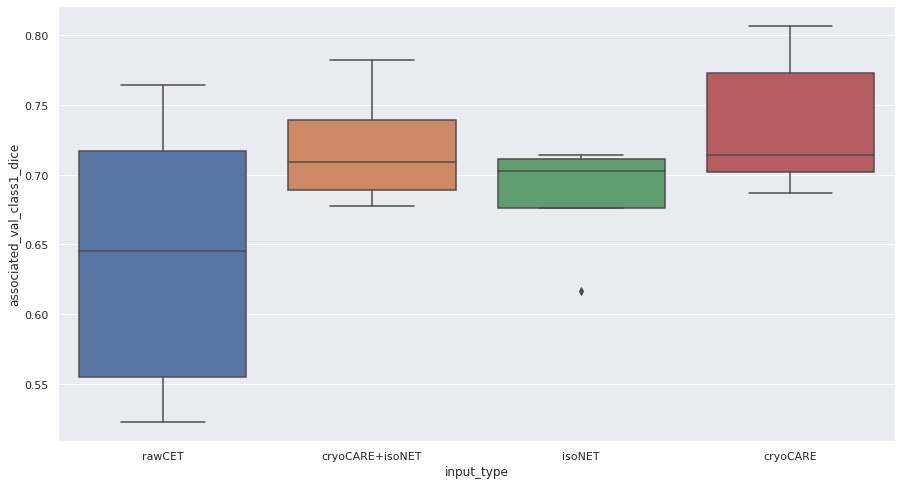

In [35]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.boxplot(x='input_type', y='associated_val_class1_dice', data=df_model[df_model.train_tomo=='train02'])

In [ ]:
# isolated analysis depending on reconstruction (denoising) process